In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download ieee-mansb-victoris-2-final-competition

ieee-mansb-victoris-2-final-competition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip ieee-mansb-victoris-2-final-competition.zip

Archive:  ieee-mansb-victoris-2-final-competition.zip
replace Sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2 ,l1
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

from sklearn.model_selection import train_test_split

import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

<ipython-input-2-b2582bf227d0>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print('GPU device found')
    print('GPU devices:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No GPU device found. Using CPU.')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU device found
GPU devices:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import keras

In [ ]:
encode_labels = {
            'Ascariasis' : 0,
            'Babesia' : 1,
            'Capillaria p' : 2,
            'Enterobius v' : 3,
            'Epidermophyton floccosum' : 4,
            'Fasciolopsis buski' : 5,
            'Hookworm egg' : 6,
            'Hymenolepis diminuta' : 7,
            'Hymenolepis nana' : 8,
            'Leishmania' : 9,
            'Opisthorchis viverrine' : 10,
            'Paragonimus spp' : 11,
            'T. rubrum' : 12,
            'Taenia spp' : 13,
            'Trichuris trichiura' : 14,
        }
decoded_labels = {value : key for key, value in encode_labels.items()}

In [ ]:
#to change number of epochs so models run faster
RUN_FAST = False

num_classes = 15
BATCH_SIZE = 80

epochs = 3 if RUN_FAST else 50

IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60
IMAGE_CHANNELS = 3

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, )
target_size = (IMAGE_SIZE + (IMAGE_CHANNELS, ))

#validation size
train_val_size = 0.3

#random state
rnd = 42

#change to dir path data is in
currdir = '/content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final'


train_batch1_dir = os.path.join(currdir, 'train_Images_Source_1')
train_batch2_dir = os.path.join(currdir, 'train_Images_Source_2')
test_dir  = os.path.join(currdir, 'test_data')

# Read the data

<br>
<br>

**- Reading `'train_Images_Source_1'`**


In [ ]:
#image file names
train_batch1_dirname = os.listdir(train_batch1_dir)
print("classes directory names:", train_batch1_dirname, sep = '\n', end = '\n\n')

train_batch1 = pd.DataFrame({'image_path' : [],
                      'image_label_name' : [],
                       'image_label' : [],})

n_of_train_b1_images = 0
display = True

for dirname in train_batch1_dirname:
    # directory path
    my_currdir = os.path.join(train_batch1_dir, dirname)

    #encoding the label
    label = encode_labels[dirname]

    #images filenames inside this dir
    image_filenames = os.listdir(my_currdir)

    #number of train images
    n_of_train_b1_images += len(image_filenames)

    #getting image full-path by joining dir path and image filename
    image_fullpath = pd.Series([os.path.join(my_currdir, x) for x in image_filenames])

    #making a dataframe with 3 columns
    class_df = pd.DataFrame({'image_path' : image_fullpath,}) #image full path
    class_df['image_label_name'] = dirname  #label name
    class_df['image_label'] = label  #label encoded

    #concat the class dataframe in with the train dataframe
    train_batch1 = pd.concat([train_batch1, class_df], axis = 0)

    if display:
        print('Current directory:', my_currdir, '\n')
        print('Label name:', dirname, '\nLabel Encoded:', label, '\n')
        print("image filename:", image_filenames[ : 2], sep = '\n', end = '\n\n')
        print("image full path:", image_fullpath[ : 2].values, sep = '\n', end = '\n\n')
        print('______________________________________________________________\n\n\n')
        display = False


#making sure all images read successfully
assert train_batch1.isna().sum().sum() == 0
assert train_batch1.shape[0] == n_of_train_b1_images

#looking at sample from the train dataframe
train_batch1.sample(10)

classes directory names:
['Taenia spp', 'Trichuris trichiura', 'Paragonimus spp', 'T. rubrum', 'Leishmania', 'Opisthorchis viverrine', 'Hymenolepis nana', 'Hymenolepis diminuta', 'Fasciolopsis buski', 'Hookworm egg', 'Enterobius v', 'Epidermophyton floccosum', 'Ascariasis', 'Capillaria p', 'Babesia']

Current directory: /content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final/train_Images_Source_1/Taenia spp 

Label name: Taenia spp 
Label Encoded: 13 

image filename:
['Taenia spp. egg_0034.jpg', 'Taenia spp. egg_0024.jpg']

image full path:
['/content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final/train_Images_Source_1/Taenia spp/Taenia spp. egg_0034.jpg'
 '/content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final/train_Images_Source_1/Taenia spp/Taenia spp. egg_0024.jpg']

______________________________________________________________





,image_path,image_label_name,image_label
304,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Opisthorchis viverrine,10.0
327,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Enterobius v,3.0
426,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Babesia,1.0
162,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Fasciolopsis buski,5.0
107,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Paragonimus spp,11.0
257,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Paragonimus spp,11.0
356,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Hymenolepis nana,8.0
183,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Enterobius v,3.0
287,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Paragonimus spp,11.0
377,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Hymenolepis nana,8.0


<br>
<br>

**- Reading `'train_Images_Source_2'`**


In [ ]:

#image file names
train_batch2_paths = os.listdir(train_batch2_dir)
print("image filename:", train_batch2_paths[ : 2], sep = '\n', end = '\n\n')

#number of train images
n_of_train_b2_images = len(train_batch2_paths)

# full image paths
filepaths = pd.Series([os.path.join(train_batch2_dir, x) for x in train_batch2_paths])
print("image full path:", filepaths[:2].values, sep = '\n', end = '\n\n')

#label name of image
label_names = pd.Series([x.split('_')[0] for x in train_batch2_paths])
print("image label name:", label_names[:2].values, sep = '\n', end = '\n\n')

#encoding label name of image
labels = label_names.map(encode_labels)
print("image label encoded:", labels[:2].values, sep = "\n", end = '\n\n')


#making dataframe of the three columns
train_batch2 = pd.DataFrame({'image_path' : filepaths,
                             'image_label_name' : label_names,
                             'image_label' : labels,})

df = pd.concat([train_batch1, train_batch2], axis = 0)

#making sure all images read successfully
n_of_train_images = n_of_train_b1_images + n_of_train_b2_images
assert df.isna().sum().sum() == 0
assert df.shape[0] == n_of_train_images


print(df.shape)
df.sample(10)

image filename:
['Paragonimus spp_3996.jpg', 'Paragonimus spp_3977.jpg']

image full path:
['/content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final/train_Images_Source_2/Paragonimus spp_3996.jpg'
 '/content/drive/MyDrive/data/IEEE ManSB VICTORIS 2.0 Final/ieee-mansb-victoris-2-final/train_Images_Source_2/Paragonimus spp_3977.jpg']

image label name:
['Paragonimus spp' 'Paragonimus spp']

image label encoded:
[11 11]

(11938, 3)


,image_path,image_label_name,image_label
3222,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Enterobius v,3.0
3172,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Enterobius v,3.0
4028,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Ascariasis,0.0
995,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Trichuris trichiura,14.0
604,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Leishmania,9.0
2945,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Hymenolepis nana,8.0
207,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Ascariasis,0.0
3563,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Epidermophyton floccosum,4.0
55,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Opisthorchis viverrine,10.0
3128,/content/drive/MyDrive/data/IEEE ManSB VICTORI...,Enterobius v,3.0


<br>
<br>

**- Reading test images**

In [ ]:
# reading all filenames in test directory
filenames = os.listdir(test_dir)
print("test images filenames:", filenames[:4], sep = "\n")

# extracting the id from filename
ids = [int(x.split('.')[0]) for x in filenames]
print("ids :", ids[:4], sep = "\n")

# creating the dataframe with ids, filenames
test = pd.DataFrame({'id' : ids, 'filename' : filenames})
print('test-set shape:', test.shape, sep = "\n")

# sorting the test dataframe by the id and reseting index
test.sort_values(by = ['id'], axis = 0, inplace = True)
test.reset_index(inplace = True, drop = True)

# droping the id column as it's no longer useful
test.drop(columns = ['id'], inplace = True)

test.head()

test images filenames:
['4679.jpg', '4665.jpg', '4669.jpg', '4690.jpg']
ids :
[4679, 4665, 4669, 4690]
test-set shape:
(5108, 2)


,filename
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg


**- spliting train to train and validation**

In [ ]:
train=df

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255)

train_datagen = train_datagen.flow_from_dataframe(
                      # dataframe to get paths from
                        dataframe = train,
                      # None because images have absolute paths
                        directory = None,
                      # column name file paths are in
                        x_col = 'image_path',
                      # column name output targets are in
                        y_col = 'image_label',
                      # size to rescale the output images to
                        target_size = IMAGE_SIZE,
                      # size of the batch
                        batch_size = BATCH_SIZE,
                      # mode "raw" output targets is array of y_col as it is
                        class_mode = 'raw',
                    )

Found 11938 validated image filenames.


In [ ]:
# Retrieve the class indices from the generator
import numpy as np

class_indices = np.arange(0, 15)
num_train_samples = train_datagen.samples
# Calculate the number of classes
num_classes = len(class_indices)

# Initialize empty arrays for X_train and Y_train
X_train = np.empty((num_train_samples, *IMAGE_SIZE, 3), dtype=np.float32)
Y_train = np.empty((num_train_samples, ), dtype=np.float32)

# Iterate through the train_datagen to obtain the image and label data
for i in range(num_train_samples // BATCH_SIZE):
    # Retrieve a batch of image and label data
    batch_x, batch_y = train_datagen.next()

    # Store the batch data in the X_train and Y_train arrays
    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE
    X_train[start_index:end_index] = batch_x
    Y_train[start_index:end_index] = batch_y

    # Optionally, you can print the progress to track the conversion
    print(f"Processed batch {i+1}/{num_train_samples // BATCH_SIZE}")

# Verify the shape of X_train and Y_train
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Number of classes:", num_classes)

Processed batch 1/149
Processed batch 2/149
Processed batch 3/149
Processed batch 4/149
Processed batch 5/149
Processed batch 6/149
Processed batch 7/149
Processed batch 8/149
Processed batch 9/149
Processed batch 10/149
Processed batch 11/149
Processed batch 12/149
Processed batch 13/149
Processed batch 14/149
Processed batch 15/149
Processed batch 16/149
Processed batch 17/149
Processed batch 18/149
Processed batch 19/149
Processed batch 20/149
Processed batch 21/149
Processed batch 22/149
Processed batch 23/149
Processed batch 24/149
Processed batch 25/149
Processed batch 26/149
Processed batch 27/149
Processed batch 28/149
Processed batch 29/149
Processed batch 30/149
Processed batch 31/149
Processed batch 32/149
Processed batch 33/149
Processed batch 34/149
Processed batch 35/149
Processed batch 36/149
Processed batch 37/149
Processed batch 38/149
Processed batch 39/149
Processed batch 40/149
Processed batch 41/149
Processed batch 42/149
Processed batch 43/149
Processed batch 44/1

In [ ]:
import numpy as np

# Assuming X_train and Y_train are already defined as arrays
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

# Verify the types of X_train and Y_train
print(type(X_train))
print(type(Y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Transformer

In [ ]:
num_classes = 15
input_shape = target_size


In [ ]:
!pip install -U tensorflow-addons
from tensorflow.keras import layers
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print(f"X_train shape: {X_train.shape} - Y_train shape: {Y_train.shape}")


X_train shape: (11938, 60, 60, 3) - Y_train shape: (11938,)


# Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 60  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Augmentation

In [ ]:
from tensorflow import keras
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)


# MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Patch Creation

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
        import matplotlib.pyplot as plt


Image size: 60 X 60
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


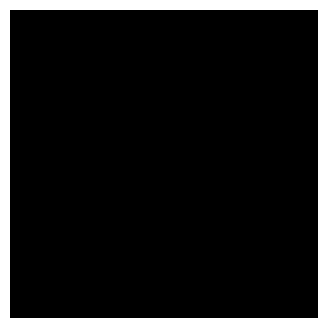

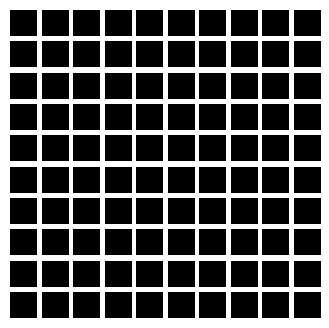

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


 # Implement the batch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# Train

In [ ]:


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=200,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )



    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
42/42 [==============================] - 30s 407ms/step - loss: 2.4891 - accuracy: 0.3472 - top-5-accuracy: 0.7329 - val_loss: nan - val_accuracy: 0.5578 - val_top-5-accuracy: 0.9271
Epoch 2/50
42/42 [==============================] - 12s 278ms/step - loss: 1.3116 - accuracy: 0.5646 - top-5-accuracy: 0.9175 - val_loss: nan - val_accuracy: 0.7010 - val_top-5-accuracy: 0.9673
Epoch 3/50
42/42 [==============================] - 11s 274ms/step - loss: 1.0338 - accuracy: 0.6548 - top-5-accuracy: 0.9549 - val_loss: nan - val_accuracy: 0.7228 - val_top-5-accuracy: 0.9765
Epoch 4/50
42/42 [==============================] - 12s 277ms/step - loss: 0.8754 - accuracy: 0.7066 - top-5-accuracy: 0.9671 - val_loss: nan - val_accuracy: 0.7487 - val_top-5-accuracy: 0.9799
Epoch 5/50
42/42 [==============================] - 11s 270ms/step - loss: 0.7638 - accuracy: 0.7427 - top-5-accuracy: 0.9768 - val_loss: nan - val_accuracy: 0.8015 - val_top-5-accuracy: 0.9791
Epoch 6/50
42/42 [============

In [ ]:
test

,filename
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg
...,...
5103,5103.jpg
5104,5104.jpg
5105,5105.jpg
5106,5106.jpg


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = test_datagen.flow_from_dataframe(
                                test,
                                test_dir,
                                x_col='filename',
                                y_col=None,
                                class_mode=None,
                                target_size= IMAGE_SIZE,
                                batch_size= BATCH_SIZE,
                                shuffle=False
                            )

Found 5108 validated image filenames.


In [ ]:
num_test_samples = test_datagen.samples

# Initialize empty arrays for X_train and Y_train
X_test = np.empty((num_test_samples, *IMAGE_SIZE, 3), dtype=np.float32)


# Iterate through the train_datagen to obtain the image and label data
for i in range(num_test_samples // BATCH_SIZE):
    # Retrieve a batch of image and label data
    batch_x = test_datagen.next()

    # Store the batch data in the X_train and Y_train arrays
    start_index = i * BATCH_SIZE
    end_index = start_index + BATCH_SIZE
    X_train[start_index:end_index] = batch_x


    # Optionally, you can print the progress to track the conversion
    print(f"Processed batch {i+1}/{num_test_samples // BATCH_SIZE}")

# Verify the shape of X_train and Y_train
print("X_train shape:", X_test.shape)

Processed batch 1/149
Processed batch 2/149
Processed batch 3/149
Processed batch 4/149
Processed batch 5/149
Processed batch 6/149
Processed batch 7/149
Processed batch 8/149
Processed batch 9/149
Processed batch 10/149
Processed batch 11/149
Processed batch 12/149
Processed batch 13/149
Processed batch 14/149
Processed batch 15/149
Processed batch 16/149
Processed batch 17/149
Processed batch 18/149
Processed batch 19/149
Processed batch 20/149
Processed batch 21/149
Processed batch 22/149
Processed batch 23/149
Processed batch 24/149
Processed batch 25/149
Processed batch 26/149
Processed batch 27/149
Processed batch 28/149
Processed batch 29/149
Processed batch 30/149
Processed batch 31/149
Processed batch 32/149
Processed batch 33/149
Processed batch 34/149
Processed batch 35/149
Processed batch 36/149
Processed batch 37/149
Processed batch 38/149
Processed batch 39/149
Processed batch 40/149
Processed batch 41/149
Processed batch 42/149
Processed batch 43/149
Processed batch 44/1

In [ ]:
pred = vit_classifier.predict(X_test)

cols = ['class_0',	'class_1',	'class_2',	'class_3',	'class_4',
           'class_5',	'class_6', 'class_7',	'class_8',	'class_9',
           'class_10',	'class_11',	'class_12',	'class_13',	'class_14']

sub = pd.read_csv(os.path.join(currdir, 'Sample_submission.csv'))
sub[cols] = pred

sub.to_csv(os.path.join(currdir, 'transformer_.csv'), index = False)
sub.head()

 58/160 [=========>....................] - ETA: 3s

 **End**